# Preprocess the data

In [1]:
# Load dataset
import pandas as pd
file_path = 'train_sortiert_new_format.csv'
df = pd.read_csv(file_path)
indices = df.index.tolist()
features = df.columns.tolist()
df.head()

,video_id,label_id,label,F1_L0_X,F1_L0_Y,F1_L0_Z,F1_L1_X,F1_L1_Y,F1_L1_Z,F1_L2_X,...,F37_L17_Z,F37_L18_X,F37_L18_Y,F37_L18_Z,F37_L19_X,F37_L19_Y,F37_L19_Z,F37_L20_X,F37_L20_Y,F37_L20_Z
0,1000,11,Sliding Two Fingers Left,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100011,20,Thumb Up,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10002,11,Sliding Two Fingers Left,0.269611,0.937481,4.710461e-07,0.302779,0.850025,-0.027882,0.300107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100031,12,Sliding Two Fingers Right,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,19,Thumb Down,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# Set constants
n_frames = 37
n_landmarks = 21
n_dimensions = 3
n_samples = len(indices)
n_features = len(features)
print(f"{n_samples} samples with {n_features} features.")
print(f"video_id + label_id + label + {n_frames} Frames * {n_landmarks} Landmarks * {n_dimensions} Dimensions -> {3+n_frames*n_landmarks*n_dimensions}")

16318 samples with 2334 features.
video_id + label_id + label + 37 Frames * 21 Landmarks * 3 Dimensions -> 2334


In [3]:
# Convert coordinates to np.arr
import numpy as np
data = np.zeros((n_samples, n_frames, n_landmarks, n_dimensions), dtype=np.float16)
dim_dict = {0: "X", 1: "Y", 2: "Z"}

# Loop through all labels and store in data array
for f in range(1,n_frames+1):
    for l in range(n_landmarks):
        for d in range(n_dimensions):
            index = "F"+str(f)+"_L"+str(l)+"_"+dim_dict[d]
            data[:,f-1,l,d] = np.array(df[index])

print("The shape of the data is:      ", data.shape) # (n_samples, n_frames, n_landmarks, n_dimensions)
print("The percentage of 0 entries is:", np.round(np.sum(data<=0) / np.size(data)*100,3),"%")
print("The array has a size of:       ", np.round(data.nbytes/1024**2,2),"MB.")

The shape of the data is:       (16318, 37, 21, 3)
The percentage of 0 entries is: 76.41 %
The array has a size of:        72.55 MB.


In [4]:
# Generate train and test data
training_split = 0.9                                    # How much data for training and testing?

# random permutation of the indices
np.random.seed(42)                                      # Fix seed for reproducibility
indices = np.random.permutation(len(data))
split_index = int(len(data) * (1 - training_split))

# generate split index & split the data
train_indices = indices[split_index:]
test_indices = indices[:split_index]
labels = np.array(df["label_id"])
x_train, x_test = data[train_indices], data[test_indices]
y_train, y_test = labels[train_indices], labels[test_indices]
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(len(x_train)," samples for training.")
print(len(x_test)," samples for testing.")
print("Labels: ", np.unique(labels))

x_train shape: (14687, 37, 21, 3)
x_test shape: (1631, 37, 21, 3)
y_train shape: (14687,)
y_test shape: (1631,)
14687  samples for training.
1631  samples for testing.
Labels:  [ 5 10 11 12 13 19 20 24 26]


Stats:  1.284 -0.761 0.1055 0.0


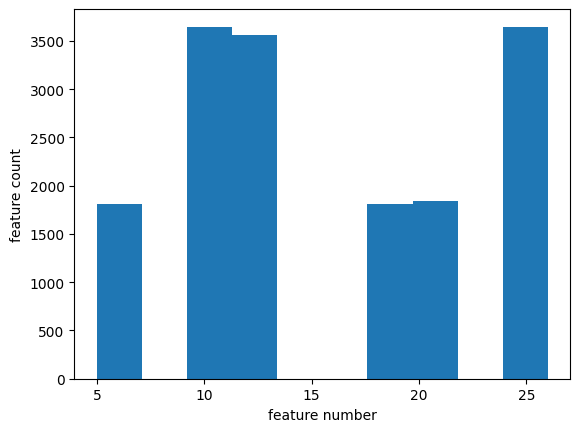

In [5]:
import matplotlib.pyplot as plt
print("Stats: ",np.max(x_train), np.min(x_train), np.mean(x_train), np.median(x_train))
plt.hist(labels)
plt.xlabel("feature number")
plt.ylabel("feature count")
plt.show()

# Train model

In [6]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import time

In [7]:
def plot_cv_curves(alphas, cv_scores):
    '''Function that plots CV results: data from each fold/alpha combination,
    average over fold and a special mark for the optimal alpha.

    inputs:
        alphas - flat array with alphas used in the CV, length (n_alphas)
        cv_scores - array accuracy values for each score/alpha combination, shape (n_folds x n_alphas)
    '''
    means = np.mean(cv_scores, axis=0)            # get array with mean accuracy values
    for i in range(len(cv_scores)):                  # plot every accuracy
      plt.plot(alphas, cv_scores[i,:])

    plt.plot(alphas, means, label="mean_acc", linewidth=5, markevery=0)    # plot means
    plt.plot(alphas[means.argmax()], np.max(means), "s", label="max_mean") # mark max mean value
    plt.title(f"max_mean_acc {np.max(means)}")
    plt.legend()        # add legend
    plt.xscale("log")   # transform to log-scale
    plt.xlabel("regularization strength")
    plt.ylabel("Accuracy")

First, let's start in the most simplest way. Let's predict with linear & logistic regression.

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train_flat, y_train)

# Predict on the test data
y_pred = model.predict(x_test_flat)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 19.929809364491923
R² Score: 0.5344721563503338
Coefficients: [  -26.48    23.77 -4384.   ...    55.88   -76.25  -116.25]
Intercept: 15.734


In [63]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=2000)  # max_iter can be adjusted if needed
model.fit(x_train_flat, y_train)

# Predict on the test data
y_pred = model.predict(x_test_flat)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy) # Best so far

Test Set Accuracy: 0.7755977927651747


In [10]:
from sklearn.linear_model import LogisticRegression
# Add l2 penalty with low reg strength, many iterations and balanced classes
model = LogisticRegression(max_iter=200, penalty="l2", C=10, class_weight="balanced", solver="saga", verbose=1)  # max_iter can be adjusted if needed
model.fit(x_train_flat, y_train)

# Predict on the test data
y_pred = model.predict(x_test_flat)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy) # Best so far

max_iter reached after 183 seconds
Test Set Accuracy: 0.776824034334764


C:\Users\flore\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [12]:
from sklearn.linear_model import LogisticRegression
# Add l2 penalty with low reg strength, many iterations and balanced classes
model = LogisticRegression(max_iter=200, penalty="l2", C=10, solver="saga", verbose=1)  # max_iter can be adjusted if needed
model.fit(x_train_flat, y_train)

# Predict on the test data
y_pred = model.predict(x_test_flat)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy) # Best so far

max_iter reached after 195 seconds
Test Set Accuracy: 0.776824034334764


C:\Users\flore\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Now, lets regularize and find a good alpha with Cross validation

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
# set shared hyperparameters
n_folds = 8
max_iter = 200
n_alpha = np.logspace(-1,3,5)
print(n_alpha)

# First l2 ridge regression
a = time.time()
logreg_ridge_cv = LogisticRegressionCV(Cs=n_alpha, cv=n_folds, random_state=1, solver='saga', max_iter=max_iter, penalty="l2", verbose=1, n_jobs=8) # set n_jobs ideally to n_folds
logreg_ridge_cv.fit(x_train_flat, y_train)
b = time.time()
print("Training took: ",np.round(b-a,2), "seconds.")

[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
[0.73997427 0.75536201 0.75910701 0.75971962 0.7594474 ]


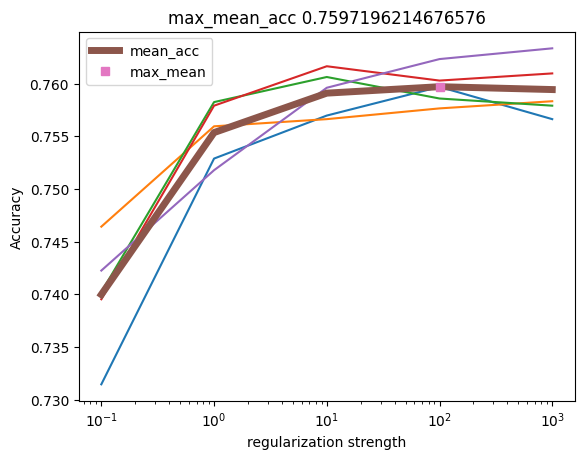

In [39]:
print(logreg_ridge_cv.Cs_)
print(logreg_ridge_cv.scores_[19].mean(axis=0))
plot_cv_curves(logreg_ridge_cv.Cs_, logreg_ridge_cv.scores_[19])

In [ ]:
# Now l1 lasso regression
a = time.time()
logreg_lasso_cv = LogisticRegressionCV(Cs=n_alpha, cv=n_folds, random_state=1, solver='saga', max_iter=max_iter, penalty="l1", verbose=1, n_jobs=8)
logreg_lasso_cv.fit(x_train_flat, y_train)
b = time.time()
print("Training took: ",np.round(b-a,2), "seconds.")

[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
[0.68502758 0.74766801 0.75679172 0.75883448 0.75971962]


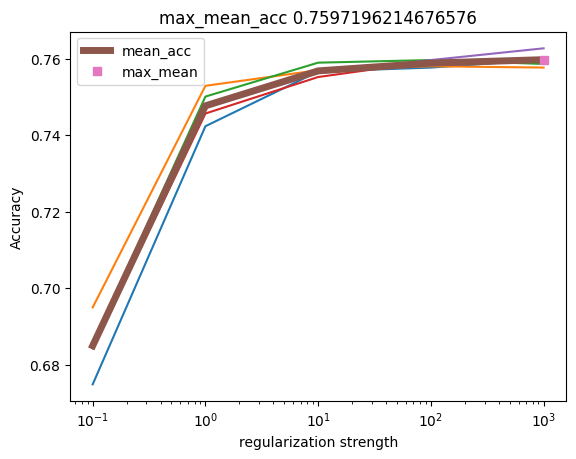

In [41]:
print(logreg_lasso_cv.Cs_)
print(logreg_lasso_cv.scores_[19].mean(axis=0))
plot_cv_curves(logreg_lasso_cv.Cs_, logreg_lasso_cv.scores_[19])

Now, let's try SVM, Decision trees, and Random Forests

In [62]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', random_state=1)
svm.fit(x_train_flat, y_train)

accuracy_svm = accuracy_score(y_test, svm.predict(x_test_flat))
print("SVM Accuracy:", accuracy_svm)

SVM Accuracy: 0.7492335990190068


In [60]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train_flat, y_train)

accuracy_dt = accuracy_score(y_test, dt.predict(x_test_flat))
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.592274678111588


In [61]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_flat, y_train)

accuracy_rf = accuracy_score(y_test, rf.predict(x_test_flat))
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.7296137339055794
